# Importing libraries

In [15]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.utils.class_weight import compute_class_weight

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.11.0


# Data extracting

In [2]:
# !mv ../data/challenges_in_representation/train ../data/
# !mv ../data/challenges_in_representation/test ../data/

# Plot sample images

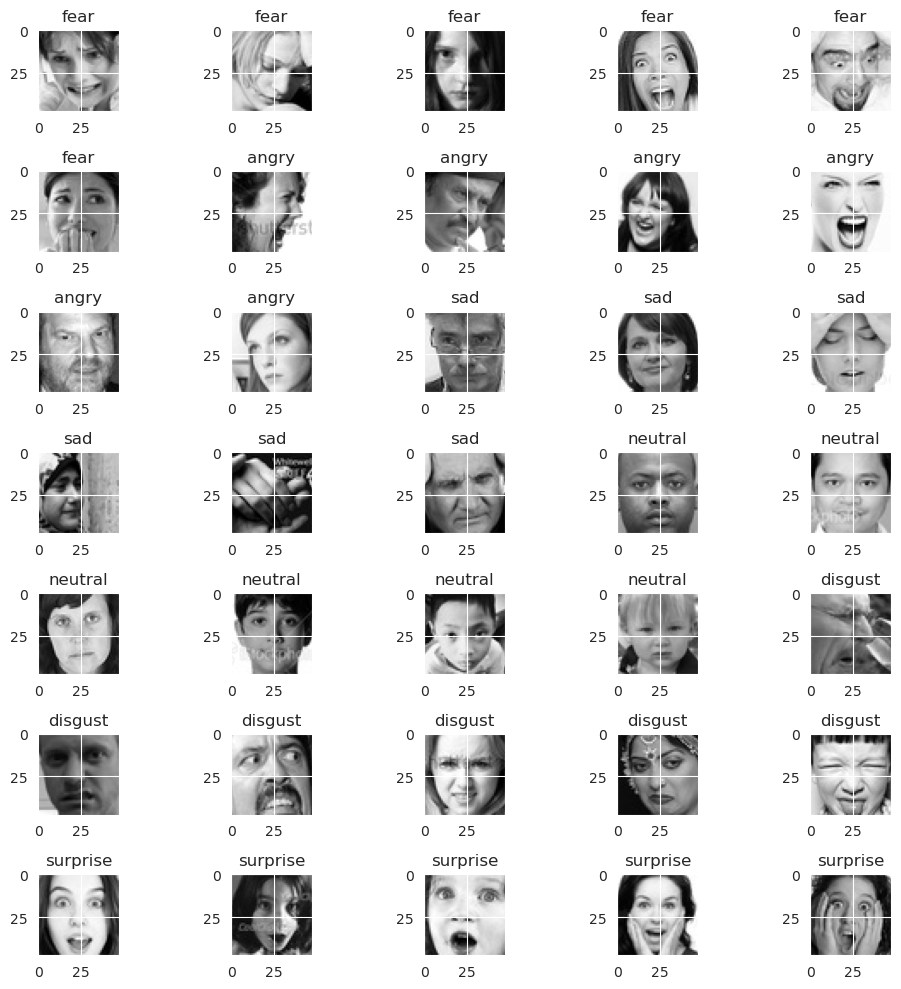

In [5]:
root_dir = "../data"
img_size = 48

def plot_example_images(root_dir, img_size):
    num_images_per_class = 5
    train_dir = os.path.join(root_dir, "train")
    plt.figure(figsize=(10, 10))
    total_subplots = 0

    for expression in os.listdir(train_dir):
        class_path = os.path.join(train_dir, expression)
        if not os.path.isdir(class_path):
            continue

        class_name = expression
        image_files = os.listdir(class_path)[:num_images_per_class]

        for i, filename in enumerate(image_files):
            if total_subplots >= 35:  # Display at most 35 images (7 rows x 5 columns)
                break

            total_subplots += 1
            plt.subplot(7, 5, total_subplots)
            img = load_img(os.path.join(class_path, filename), target_size=(img_size, img_size), color_mode="grayscale")
            plt.imshow(img, cmap='gray')
            plt.title(class_name)

    plt.tight_layout()
    plt.show()

plot_example_images(root_dir=root_dir, img_size=img_size)

# Data Distribution

In [6]:
def display_data_distribution(data_type):
    data_directory = os.path.join(root_dir, data_type)
    total_images = 0  # Initialize total images counter
    
    for expression in os.listdir(data_directory):
        expression_path = os.path.join(data_directory, expression)
        num_images = len(os.listdir(expression_path))
        total_images += num_images
        print(f"{num_images} {expression} images in {data_type} folder")
    
    print(f"Total images in {data_type.capitalize()} folder: {total_images}")  

In [7]:
display_data_distribution("train")

4097 fear images in train folder
3995 angry images in train folder
4830 sad images in train folder
4965 neutral images in train folder
436 disgust images in train folder
3171 surprise images in train folder
7214 happy images in train folder
Total images in Train folder: 28708


In [8]:
display_data_distribution("test")

1024 fear images in test folder
958 angry images in test folder
1247 sad images in test folder
1233 neutral images in test folder
111 disgust images in test folder
831 surprise images in test folder
1774 happy images in test folder
Total images in Test folder: 7178


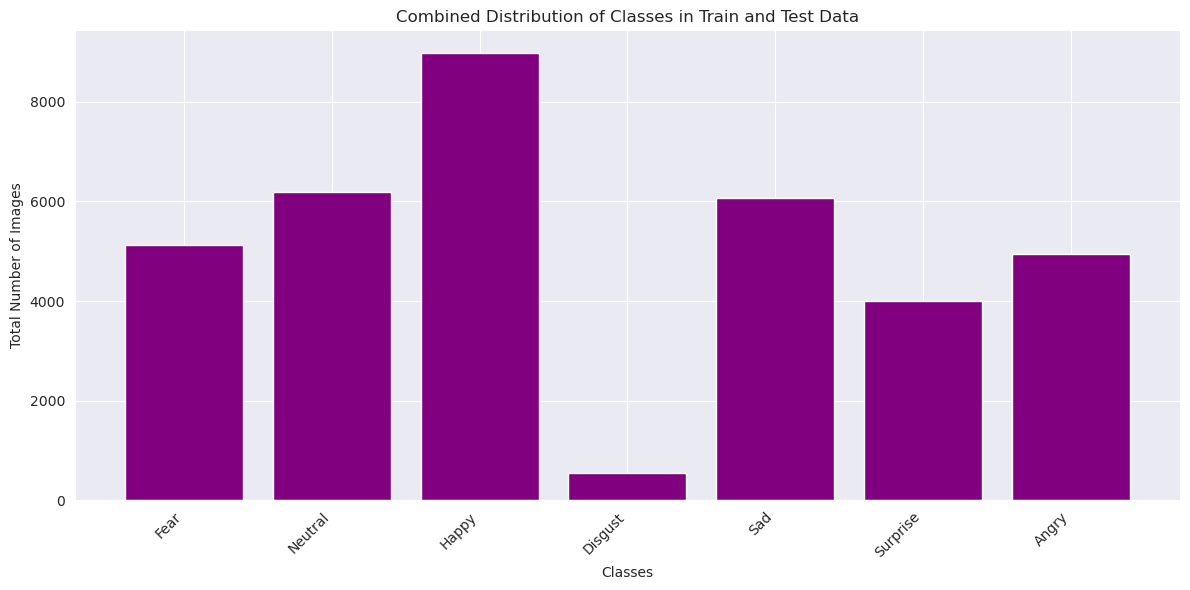

In [9]:
def plot_combined_data_distribution():
    train_directory = os.path.join(root_dir, "train")
    test_directory = os.path.join(root_dir, "test")
    train_dist = {}
    test_dist = {}

    # Calculate number of images for each class in the train directory
    for expression in os.listdir(train_directory):
        expression_path = os.path.join(train_directory, expression)
        num_images = len(os.listdir(expression_path))
        train_dist[expression.capitalize()] = num_images

    # Calculate number of images for each class in the test directory
    for expression in os.listdir(test_directory):
        expression_path = os.path.join(test_directory, expression)
        num_images = len(os.listdir(expression_path))
        test_dist[expression.capitalize()] = num_images

    # Summing the total number of images for each class across train and test directories
    combined_dist = {key: train_dist.get(key, 0) + test_dist.get(key, 0) for key in set(train_dist) | set(test_dist)}

    classes = list(combined_dist.keys())
    values = list(combined_dist.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, values, color='purple')
    plt.title("Combined Distribution of Classes in Train and Test Data")
    plt.xlabel("Classes")
    plt.ylabel("Total Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_combined_data_distribution()

# Training and validation batch

In [39]:
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(
    os.path.join(root_dir, "train"),
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(
    os.path.join(root_dir, "test"),
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Create CNN Model

In [41]:
model_name = "NeuroVisionNet"
class MyModel:
    """
    A class to build a Neural Network model using Keras Sequential API.

    Attributes:
        input_shape (tuple): Shape of the input data (height, width, channels).
        num_classes (int): Number of output classes.
        model (Sequential): Keras Sequential model.
    """

    def __init__(self, input_shape=(48, 48, 1), num_classes=7):
        """
        Initializes the MyModel class.

        Args:
            input_shape (tuple, optional): Shape of the input data (height, width, channels). Defaults to (48, 48, 1).
            num_classes (int, optional): Number of output classes. Defaults to 7.
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the neural network model using Convolutional and Dense layers.

        Returns:
            Sequential: Keras Sequential model.
        """
        model = Sequential(name=model_name)  # Using model_name defined outside the class

        # Convolutional layers
        conv_layers = [
            (64, (3, 3)),
            (128, (5, 5)),
            (512, (3, 3)),
            (512, (3, 3))
        ]

        for filters, kernel_size in conv_layers:
            model.add(Conv2D(filters, kernel_size, padding='same', input_shape=self.input_shape))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.25))

        model.add(Flatten())

        # Dense layers
        dense_layers = [256, 512]
        for units in dense_layers:
            model.add(Dense(units))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(Dropout(0.25))

        model.add(Dense(self.num_classes, activation='softmax'))

        opt = Adam(learning_rate=1e-6)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        return model


neuro_vision_net = MyModel()
neuro_vision_net.model.summary()


Model: "NeuroVisionNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_162 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_162 (Activation)  (None, 48, 48, 64)       0         
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 24, 24, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_162 (Dropout)       (None, 24, 24, 64)        0         
                                                                 
 conv2d_109 (Conv2D)         (None, 24, 24, 128)    

# Training and evaluation function

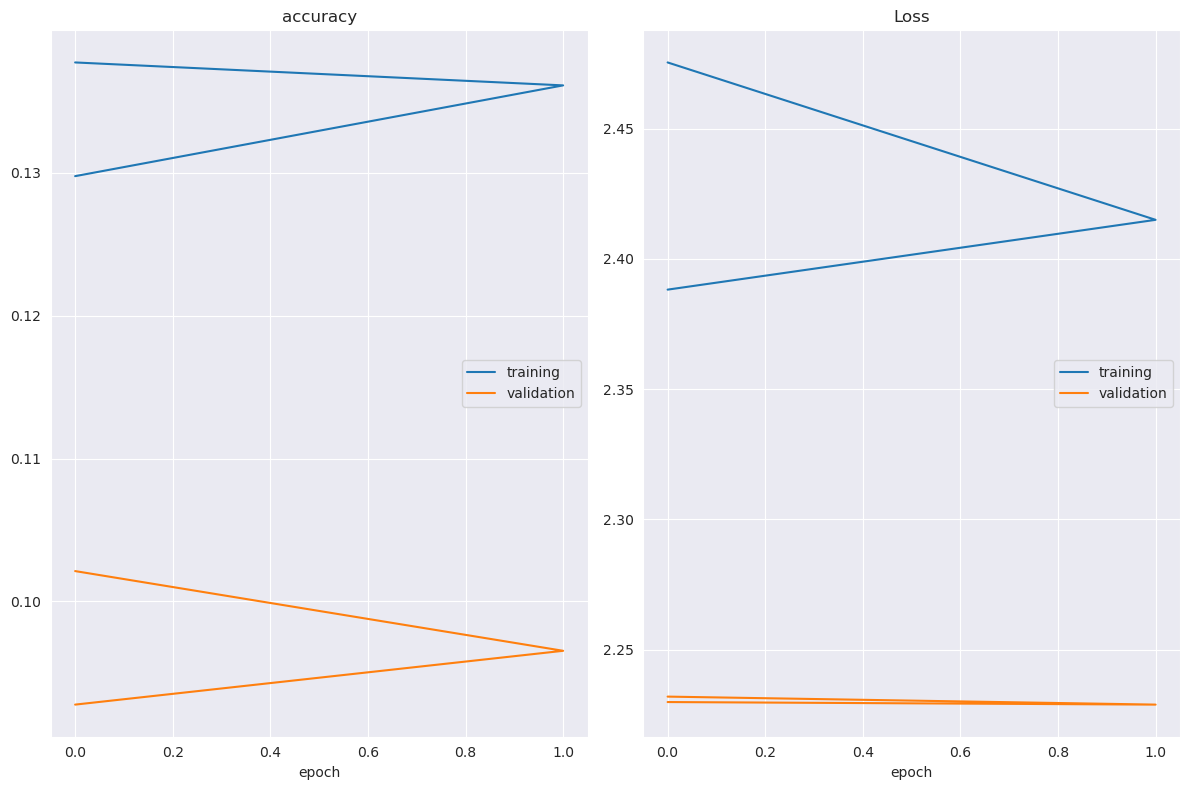

accuracy
	training         	 (min:    0.130, max:    0.138, cur:    0.138)
	validation       	 (min:    0.093, max:    0.102, cur:    0.102)
Loss
	training         	 (min:    2.388, max:    2.475, cur:    2.388)
	validation       	 (min:    2.229, max:    2.232, cur:    2.230)

Epoch 1: saving model to ../models/model_weights.h5
448/448 [==============================] - 278s 620ms/step - loss: 2.3882 - accuracy: 0.1377 - val_loss: 2.2299 - val_accuracy: 0.1021 - lr: 1.0000e-06
Epoch 2/2
 51/448 [==>...........................] - ETA: 3:53 - loss: 2.3664 - accuracy: 0.1425

KeyboardInterrupt: 

In [46]:
def calculate_steps(data_generator):
    """
    Calculate the number of steps per epoch for a given data generator.

    Args:
        data_generator: Data generator object.

    Returns:
        int: Number of steps per epoch.
    """
    return data_generator.n // data_generator.batch_size

def calculate_class_weights(train_generator):
    """
    Calculate class weights for imbalanced datasets using compute_class_weight.

    Args:
        train_generator: Training data generator.

    Returns:
        dict: Class weights dictionary.
    """
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    return dict(enumerate(class_weights))

def setup_callbacks():
    """
    Set up callbacks for the neural network training.

    Returns:
        list: List of Keras callbacks.
    """
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        min_lr=0.00001,
        mode='auto'
    )
    checkpoint = ModelCheckpoint(
        "../models/model_weights.h5",
        monitor='val_accuracy',
        save_weights_only=True,
        mode='max',
        verbose=1
    )
    return [PlotLossesKerasTF(), checkpoint, reduce_lr]

def train_neural_network(neuro_vision_net, train_generator, validation_generator, epochs=2):
    """
    Train a neural network model using the given generators.

    Args:
        neuro_vision_net: Neural network model.
        train_generator: Training data generator.
        validation_generator: Validation data generator.
        epochs (int, optional): Number of epochs for training. Defaults to 2.
    """
    steps_per_epoch = calculate_steps(train_generator)
    validation_steps = calculate_steps(validation_generator)
    
    class_weights_dict = calculate_class_weights(train_generator)
    callbacks = setup_callbacks()

    history = {}  # Store training history
    for epoch in tqdm(range(epochs), desc="Epoch"):
        try:
            neuro_vision_net.model.fit(
                x=train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=validation_steps,
                class_weight=class_weights_dict,
                callbacks=callbacks
            )
        except Exception as e:
            print(f"Error occurred during epoch {epoch + 1}: {e}")
            # Handle the error as needed

# Measure the time taken for training
train_neural_network(neuro_vision_net, train_generator, validation_generator, epochs=30)

# Store model as JSON

In [13]:
model_json = neuro_vision_net.to_json(indent=4)
with open(f"../models/{model_name}.json", "w") as json_file:
    json_file.write(model_json)